In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from unittest.mock import inplace
from IPython.display import set_matplotlib_formats
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, KFold
from random import randint

from scipy.io import loadmat
import seaborn as sns
import glob
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import datetime
import math
import time
import datetime
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
warnings.filterwarnings(action='ignore')
#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

# Korean Font Setting
plt.rcParams["font.family"] = 'Malgun Gothic'

In [2]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

dataset5, capacity5 = load_data('B0005')
dataset6, capacity6 = load_data('B0006')
dataset7, capacity7 = load_data('B0007')
pd.set_option('display.max_columns', 10)
display(dataset5)
dataset5.describe() 

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  \
0          1                   24 2008-04-02 15:25:41  1.856487   
1          1                   24 2008-04-02 15:25:41  1.856487   
2          1                   24 2008-04-02 15:25:41  1.856487   
3          1                   24 2008-04-02 15:25:41  1.856487   
4          1                   24 2008-04-02 15:25:41  1.856487   
...      ...                  ...                 ...       ...   
50280    168                   24 2008-05-27 20:45:42  1.325079   
50281    168                   24 2008-05-27 20:45:42  1.325079   
50282    168                   24 2008-05-27 20:45:42  1.325079   
50283    168                   24 2008-05-27 20:45:42  1.325079   
50284    168                   24 2008-05-27 20:45:42  1.325079   

       voltage_measured  current_measured  temperature_measured  current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       voltage_load      time  
0             0.000     0.000  
1             4.206    16.781  
2             3.062    35.703  
3             3.030    53.781  
4             3.011    71.922  
...             ...       ...  
50280         0.000  2781.312  
50281         0.000  2791.062  
50282         0.000  2800.828  
50283         0.000  2810.640  
50284         0.000  2820.390  

[50285 rows x 10 columns]

cycle  ambient_temperature      capacity  voltage_measured  \
count  50285.000000              50285.0  50285.000000      50285.000000   
mean      88.125942                 24.0      1.560345          3.515268   
std       45.699687                  0.0      0.182380          0.231778   
min        1.000000                 24.0      1.287453          2.455679   
25%       50.000000                 24.0      1.386229          3.399384   
50%       88.000000                 24.0      1.538237          3.511664   
75%      127.000000                 24.0      1.746871          3.660903   
max      168.000000                 24.0      1.856487          4.222920   

       current_measured  temperature_measured  current_load  voltage_load  \
count      50285.000000          50285.000000  50285.000000  50285.000000   
mean          -1.806032             32.816991      1.362700      2.308406   
std            0.610502              3.987515      1.313698      0.800300   
min           -2.029098             23.214802     -1.998400      0.000000   
25%           -2.013415             30.019392      1.998000      2.388000   
50%           -2.012312             32.828944      1.998200      2.533000   
75%           -2.011052             35.920887      1.998200      2.690000   
max            0.007496             41.450232      1.998400      4.238000   

               time  
count  50285.000000  
mean    1546.208924  
std      906.640295  
min        0.000000  
25%      768.563000  
50%     1537.031000  
75%     2305.984000  
max     3690.234000

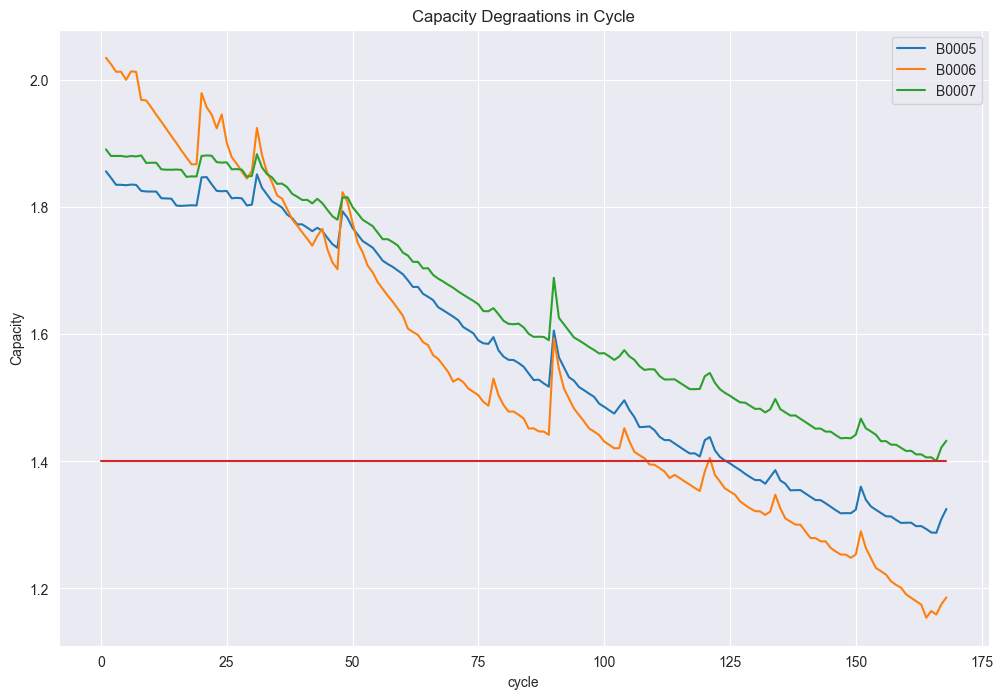

In [3]:
plot_df5 = capacity5.loc[(capacity5['cycle']>=1),['cycle','capacity']]
plot_df6 = capacity6.loc[(capacity6['cycle']>=1),['cycle','capacity']]
plot_df7 = capacity7.loc[(capacity7['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df5['cycle'], plot_df5['capacity'], label='B0005')
plt.plot(plot_df6['cycle'], plot_df6['capacity'], label='B0006')
plt.plot(plot_df7['cycle'], plot_df7['capacity'], label='B0007')
#Draw threshold
plt.plot([0.,len(capacity5)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Capacity Degraations in Cycle')
plt.legend(loc='best')

In [4]:
cap5 = capacity5.capacity.values
cap6 = capacity6.capacity.values
cap7 = capacity7.capacity.values

In [5]:
def extract_charge_preprocessing(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  charInput = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    try:
      row = mat[battery][0, 0]['cycle'][0, i]
      
      if row['type'][0] == 'charge':
        le = len(row['data']['Voltage_measured'][0][0][0]) % 10
        vTemp = row['data']['Voltage_measured'][0][0][0][:] if le ==0 else row['data']['Voltage_measured'][0][0][0][:-le] 
        if vTemp.shape[0] ==0:
          continue
        vTemp = vTemp.reshape(-1, len(vTemp)//10)
        vTemp = np.mean(vTemp,axis=1)

        iTemp = row['data']['Current_measured'][0][0][0][:] if le ==0 else row['data']['Current_measured'][0][0][0][:-le]   
        iTemp = iTemp.reshape(-1, len(iTemp)//10)
        iTemp = np.mean(iTemp,axis=1)

        tTemp = row['data']['Temperature_measured'][0][0][0][:] if le ==0 else row['data']['Temperature_measured'][0][0][0][:-le]
        tTemp = tTemp.reshape(-1, len(tTemp)//10)
        tTemp = np.mean(tTemp,axis=1)            
        charInput.append(np.concatenate([vTemp, iTemp, tTemp]))
    except Exception as e:
      print(i)

      print(e)

  charInput = np.array(charInput)
  charInput = charInput[~np.all(charInput == 0, axis=1)]

  return charInput

charInput5 = extract_charge_preprocessing('B0005')
charInput6 = extract_charge_preprocessing('B0006')
charInput7 = extract_charge_preprocessing('B0007')

Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  616


In [6]:
InitC5 = 1.86
InitC6 = 2.04
InitC7 = 1.89

def minmax_norm(charInput, InitC, cap):
    r = np.max(charInput, axis=0) - np.min(charInput, axis=0)
    xData = (charInput - np.min(charInput, axis=0)) / r
    comp = charInput.shape[0] - len(cap)
    yData = np.concatenate([InitC * np.ones(comp), cap])
    ym = np.min(yData)
    yr = np.max(yData) - np.min(yData)
    yData = (yData - ym) / yr

    return xData, yData, ym, yr

[xB5, yB5, ym5, yr5] = minmax_norm(charInput5, InitC5, cap5)
[xB6, yB6, ym6, yr6] = minmax_norm(charInput6, InitC6, cap6)
[xB7, yB7, ym7, yr7] = minmax_norm(charInput7, InitC7, cap7)

In [123]:
# case =5
# train_test_dict = {}
# train_size = 0.8
# if case ==5:
#     train_len = int(len(xB5) * train_size)
#     train_test_dict['train_x'], train_test_dict['train_y'] = xB5[:train_len,:], yB5[:train_len]
#     train_test_dict['test_x'], train_test_dict['test_y'] = xB5[train_len:, :], yB5[train_len:]
#     train_test_dict['yr'], train_test_dict['ym'] = yr5, ym5
# elif case == 6:
#     train_len = int(len(xB6) * train_size)
#     train_test_dict['train_x'], train_test_dict['train_y'] = xB6[:train_len,:], yB6[:train_len]
#     train_test_dict['test_x'], train_test_dict['test_y'] = xB6[train_len:, :], yB6[train_len:]
#     train_test_dict['yr'], train_test_dict['ym'] = yr6, ym6
# else:
#     train_len = int(len(xB7) * train_size)
#     train_test_dict['train_x'], train_test_dict['train_y'] = xB7[:train_len,:], yB7[:train_len]
#     train_test_dict['test_x'], train_test_dict['test_y'] = xB7[train_len:, :], yB7[train_len:]
#     train_test_dict['yr'], train_test_dict['ym'] = yr7, ym7

In [53]:
def data_split(X_in, Y_in):

    train_test_dict = dict()
    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X_in, Y_in, test_size=0.2, random_state=2020, shuffle=True)
    scaler.fit(X_train)
    scaled_x_train = scaler.transform(X_train)
    scaled_x_test = scaler.transform(X_test)
    train_test_dict['test_x'] = scaled_x_test
    train_test_dict['test_y'] = y_test
    train_test_dict['train_x'] = scaled_x_train
    train_test_dict['train_y'] = y_train

    return train_test_dict

case =5

train_size = 0.8
if case ==5:
    train_test_dict = data_split(xB5, yB5)
    train_test_dict['yr'], train_test_dict['ym'] = yr5, ym5
elif case == 6:
    train_test_dict = data_split(xB6, yB6)
    train_test_dict['yr'], train_test_dict['ym'] = yr6, ym6
else:
    train_test_dict = data_split(xB7, yB7)
    train_test_dict['yr'], train_test_dict['ym'] = yr7, ym7


In [54]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np
from torch.utils import data


In [55]:

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# torch data loader 에 넣어주기 위한 Dataset class

class My_Dataset(data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [56]:
import torch.nn.init as init

class FNN(nn.Module):
    def __init__(self,input_size,n_out):
        super().__init__()
        self.n_out = n_out
        self.enc_size = [input_size, 8,16,32,8]

        self.layers = nn.ModuleList([self._make_block(in_f, out_f) for in_f, out_f in zip(self.enc_size, self.enc_size[1:])]) # enc_size를 기준으로 mlp block 생성,
        self.output_layer = nn.Linear(self.enc_size[-1], self.n_out)

        self.dropout_p = 0.25
        self.drop_layer = nn.Dropout(p=self.dropout_p) # Linear Layer 통과 시 마다 drop out 진행 

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        x = self.drop_layer(x)
        x = self.output_layer(x)
        return x

    def _make_block(self, input_num, output_num): # linear - batchnorm - Relu 구조가 1 block
        return nn.Sequential(
            nn.Linear(input_num, output_num),
            nn.ReLU())



class LSTM(nn.Module):
    def __init__(self,input_size,hidden_dim,seq_len, layers, n_out):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.layers = layers
        self.n_out = n_out

        self.lstm = nn.LSTM(input_size, self.hidden_dim, num_layers=self.layers, batch_first=False) # LSTM layer
        self.fc = nn.Linear(self.hidden_dim, self.n_out, bias = False) 

    def reset_hidden_state(self): 
        self.hidden = (torch.zeros(self.layers, self.seq_len, self.hidden_dim), # 
                       torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()

        # VGGNet Style
        self.conv1 = nn.Conv1d(input_size[1], 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(32)

        # self.conv4 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.bn4 = nn.BatchNorm1d(64)
        # self.conv5 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(64)
        # self.conv6 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        # self.bn6 = nn.BatchNorm1d(64)


        # self.conv7 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        # self.bn7 = nn.BatchNorm1d(128)
        # self.conv8 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.bn8 = nn.BatchNorm1d(128)
        # self.conv9 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.bn9 = nn.BatchNorm1d(128)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 32)
        self.bn10 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn11 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        # x = torch.relu(self.bn4(self.conv4(x)))
        # x = torch.relu(self.bn5(self.conv5(x)))
        # x = torch.relu(self.bn6(self.conv6(x)))

        # x = torch.relu(self.bn7(self.conv7(x)))
        # x = torch.relu(self.bn8(self.conv8(x)))
        # x = torch.relu(self.bn9(self.conv9(x)))

        x = self.flatten(x)
        x = torch.relu(self.bn10(self.fc1(x)))
        x = torch.relu(self.bn11(self.fc2(x)))
        x = self.fc3(x)

        return x


In [57]:

class Model_Learner():

    def __init__(self, DEVICE, type='dnn'):
        self.DEVICE = DEVICE
        self.type = type
        self.train_dict = {'dnn': self.dnn_train,'cnn': self.cnn_train, 'lstm': self.lstm_train} # 각 model type에 따라 train 함수를 다르게 호출한다.
        self.eval_dict = {'dnn': self.dnn_evaluate,'cnn': self.cnn_evaluate, 'lstm': self.lstm_evaluate} # 각 model type에 따라 evaluate 함수를 다르게 호출한다.
        self.loss_dict = {'dnn': torch.nn.L1Loss,'cnn': torch.nn.MSELoss, 'lstm': torch.nn.MSELoss} # 각 model type에 따라 loss 함수를 다르게 호출한다.

    # 모델 별로 학습을 하기 위한 함수
    def nn_learning(self, nn_model, ls_dict, data_dict):

        optimizer = torch.optim.Adam(nn_model.parameters(), lr=ls_dict['learning_rate'])

        train_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['train_x'], data_dict['train_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                   batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

        test_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['test_x'], data_dict['test_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                  batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

        criterion = self.loss_dict[self.type]().to(self.DEVICE)

        test_loss = 0
        
        patience = ls_dict['patience']

        self.avg_train_losses = []
        self.avg_valid_losses = []

        early_stopping = EarlyStopping(patience=patience, verbose=True)
        best_model = None

        for epoch in range(1, ls_dict['EPOCHS'] + 1):
            train_loss = self.train_dict[self.type](nn_model, train_loader, optimizer, criterion)
            test_loss = self.eval_dict[self.type](nn_model, test_loader, criterion)

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(test_loss)

            if epoch % 10 == 0:
                print('epoch:{} train_loss:{:.4f}'.format(epoch, train_loss))
                print('validation_loss:{:.4f}'.format(test_loss))
                best_model = early_stopping(test_loss, nn_model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        
        if best_model is None: best_model = nn_model

        best_model.eval()
        test_x = data_dict['test_x'].reshape(-1, 30, 1) if self.type == 'cnn' else data_dict['test_x']
        output = best_model(torch.from_numpy(test_x.astype(np.float32)).to(self.DEVICE)).cpu().squeeze()

        self.output_np = output.detach().numpy()

        return best_model, self.output_np

    def dnn_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                optimizer.zero_grad()
                hypothesis = model(data.type(torch.float32)).squeeze()
                loss = criterion(hypothesis, target)
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)

    
    def cnn_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                
                data = data.reshape(-1, 30, 1)
                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                optimizer.zero_grad()
                hypothesis = model(data.type(torch.float32)).squeeze()
                loss = criterion(hypothesis, target)
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)


    def lstm_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                model.reset_hidden_state()
                hypothesis = model(data.type(torch.float32))
                
                loss = criterion(hypothesis, target)

                optimizer.zero_grad()
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)

    def dnn_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0


            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)

                    hypothesis = model(data.type(torch.float32)).squeeze()
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

    def cnn_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0


            with torch.no_grad():
                for data, target in test_loader:
                
                    data = data.reshape(-1, 30, 1)
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)

                    hypothesis = model(data.type(torch.float32)).squeeze()
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

    def lstm_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0


            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                    model.reset_hidden_state()

                    hypothesis = model(data.type(torch.float32))
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

In [58]:
import torch
import random

torch.manual_seed(4)
np.random.seed(10)
random.seed(0)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print(DEVICE)

ls_dict = {'learning_rate': 1e-3, 'EPOCHS': 50, 'BATCH_SIZE': 20, 'patience': 5}

train_model = FNN(train_test_dict['train_x'].shape[1], 1).to(DEVICE)

optimizer = torch.optim.Adam(train_model.parameters(), lr=ls_dict['learning_rate'])

train_loader = torch.utils.data.DataLoader(dataset=My_Dataset(train_test_dict['train_x'], train_test_dict['train_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                   batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(dataset=My_Dataset(train_test_dict['test_x'], train_test_dict['test_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                  batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

criterion = torch.nn.L1Loss().to(DEVICE)


net_learning = Model_Learner(DEVICE=DEVICE, type='dnn')
wc_mlp_best, pred_df = net_learning.nn_learning(nn_model=train_model,
                                                ls_dict=ls_dict,
                                                data_dict=train_test_dict)


y = torch.from_numpy(train_test_dict['test_y'].astype(np.float32)).cpu()
y_df = y.numpy()
y_df = y_df * train_test_dict['yr'] + train_test_dict['ym']

pred_df = pred_df * train_test_dict['yr'] + train_test_dict['ym']

cpu
epoch:10 train_loss:0.0129
validation_loss:0.0086
Validation loss decreased (inf --> 0.008637).
epoch:20 train_loss:0.0075
validation_loss:0.0053
Validation loss decreased (0.008637 --> 0.005263).
epoch:30 train_loss:0.0065
validation_loss:0.0027
Validation loss decreased (0.005263 --> 0.002721).
epoch:40 train_loss:0.0059
validation_loss:0.0033
EarlyStopping counter: 1 out of 5
epoch:50 train_loss:0.0056
validation_loss:0.0030
Validation loss decreased (0.003347 --> 0.003000).


In [59]:
pred_y_df = pd.DataFrame(y_df, columns=['real'])

pred_y_df['pred'] = pred_df


In [60]:
plt.plot(pred_y_df['real'])
plt.plot(pred_y_df['pred'])


# 1d CNN


In [61]:
import torch
import random

torch.manual_seed(4)
np.random.seed(10)
random.seed(0)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print(DEVICE)

ls_dict = {'learning_rate': 1e-3, 'EPOCHS': 50, 'BATCH_SIZE': 20, 'patience': 5}

train_model = CNN1D(train_test_dict['train_x'].shape).to(DEVICE)

optimizer = torch.optim.Adam(train_model.parameters(), lr=ls_dict['learning_rate'])

train_loader = torch.utils.data.DataLoader(dataset=My_Dataset(train_test_dict['train_x'], train_test_dict['train_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                   batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(dataset=My_Dataset(train_test_dict['test_x'], train_test_dict['test_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                  batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

criterion = torch.nn.L1Loss().to(DEVICE)

net_learning = Model_Learner(DEVICE=DEVICE, type='cnn')
wc_mlp_best, pred_df = net_learning.nn_learning(nn_model=train_model,
                                                ls_dict=ls_dict,
                                                data_dict=train_test_dict)


y = torch.from_numpy(train_test_dict['test_y'].astype(np.float32)).cpu()
y_df = y.numpy()
y_df = y_df * train_test_dict['yr'] + train_test_dict['ym']

pred_df = pred_df * train_test_dict['yr'] + train_test_dict['ym']

cpu
epoch:10 train_loss:0.0005
validation_loss:0.0027
Validation loss decreased (inf --> 0.002670).
epoch:20 train_loss:0.0001
validation_loss:0.0014
Validation loss decreased (0.002670 --> 0.001373).
epoch:30 train_loss:0.0001
validation_loss:0.0016
EarlyStopping counter: 1 out of 5
epoch:40 train_loss:0.0001
validation_loss:0.0012
Validation loss decreased (0.001558 --> 0.001194).
epoch:50 train_loss:0.0000
validation_loss:0.0011
Validation loss decreased (0.001194 --> 0.001103).


In [62]:
pred_y_df = pd.DataFrame(y_df, columns=['real'])

pred_y_df['pred'] = pred_df
plt.plot(pred_y_df['real'])
plt.plot(pred_y_df['pred'])

## LSTM

In [63]:
## time series sequence feature 

def build_dataset(time_series,target, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - (seq_length)):
        _x = time_series[i:i + seq_length, :]
        _y = target[i + seq_length]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)


In [64]:
train_test_lstm_dict = {}

train_test_lstm_dict['train_x'], train_test_lstm_dict['train_y'] = np.expand_dims(train_test_dict['train_x'], axis=1), train_test_dict['train_y']
train_test_lstm_dict['test_x'],train_test_lstm_dict['test_y'] = np.expand_dims(train_test_dict['test_x'], axis=1), train_test_dict['test_y']

In [65]:
train_test_lstm_dict['train_x'].shape

(135, 1, 30)

In [66]:
hidden_dim = 50
output_dim = 1 
learning_rate = 1e-3


torch.manual_seed(17)
np.random.seed(10)
random.seed(0)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")


print(DEVICE)

ls_dict = {'learning_rate': learning_rate, 'EPOCHS': 100, 'BATCH_SIZE': 50, 'patience': 5}


train_model = LSTM(input_size=train_test_lstm_dict['train_x'].shape[2], hidden_dim=hidden_dim, seq_len=1, n_out=1, layers=1).to(DEVICE)
print(train_model)

net_learning = Model_Learner(DEVICE=DEVICE, type='lstm')
wc_lstm_best, pred_df = net_learning.nn_learning(nn_model=train_model,
                                                ls_dict=ls_dict,
                                                data_dict=train_test_lstm_dict)


y = torch.from_numpy(train_test_lstm_dict['test_y'].astype(np.float32)).cpu()
y_df = y.numpy()
y_df = y_df * train_test_dict['yr'] + train_test_dict['ym']

pred_df = pred_df * train_test_dict['yr'] + train_test_dict['ym']

cpu
LSTM(
  (lstm): LSTM(30, 50)
  (fc): Linear(in_features=50, out_features=1, bias=False)
)
epoch:10 train_loss:0.0027
validation_loss:0.0036
Validation loss decreased (inf --> 0.003622).
epoch:20 train_loss:0.0025
validation_loss:0.0036
Validation loss decreased (0.003622 --> 0.003572).
epoch:30 train_loss:0.0025
validation_loss:0.0036
EarlyStopping counter: 1 out of 5
epoch:40 train_loss:0.0025
validation_loss:0.0036
Validation loss decreased (0.003586 --> 0.003566).
epoch:50 train_loss:0.0025
validation_loss:0.0035
Validation loss decreased (0.003566 --> 0.003547).
epoch:60 train_loss:0.0024
validation_loss:0.0035
Validation loss decreased (0.003547 --> 0.003530).
epoch:70 train_loss:0.0024
validation_loss:0.0035
Validation loss decreased (0.003530 --> 0.003515).
epoch:80 train_loss:0.0024
validation_loss:0.0035
Validation loss decreased (0.003515 --> 0.003501).
epoch:90 train_loss:0.0024
validation_loss:0.0035
Validation loss decreased (0.003501 --> 0.003488).
epoch:100 train_los

In [67]:
pred_df

array([1.488312 , 1.507268 , 1.5351365, 1.5415374, 1.5613633, 1.5528305,
       1.556895 , 1.5632789, 1.5889064, 1.5832613, 1.5887513, 1.5898684,
       1.5908732, 1.5769799, 1.5651757, 1.548985 , 1.5425042, 1.5659108,
       1.5803204, 1.5678955, 1.5550494, 1.569482 , 1.5707664, 1.5905973,
       1.5773277, 1.5761665, 1.5564116, 1.5595343, 1.5704348, 1.559819 ,
       1.5589345, 1.538204 , 1.5517125, 1.5563776], dtype=float32)

In [68]:
pred_y_df = pd.DataFrame(y_df, columns=['real'])

pred_y_df['pred'] = pred_df


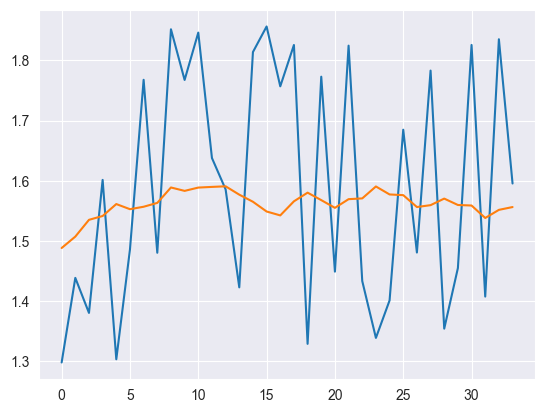

In [69]:
plt.plot(pred_y_df['real'])
plt.plot(pred_y_df['pred'])

In [70]:

from xgboost import XGBRegressor

In [71]:

def xgb(params=None):
        
    xgb_model = XGBRegressor(**params) if params is not None else XGBRegressor()
    return xgb_model


In [72]:
xgb_model = xgb()
xgb_model.fit(train_test_dict['train_x'], train_test_dict['train_y'])



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [73]:
pred_df = xgb_model.predict(train_test_dict['test_x'])

y_df = train_test_dict['test_y'] * train_test_dict['yr'] + train_test_dict['ym']

pred_df = pred_df * train_test_dict['yr'] + train_test_dict['ym']

In [74]:
pred_y_df = pd.DataFrame(y_df, columns=['real'])

pred_y_df['pred'] = pred_df
plt.plot(pred_y_df['real'])
plt.plot(pred_y_df['pred'])